# Attention Tutorial

One of the most influential and interesting new neural networks types is the attention network. It's been used succesfully in translation services, [medical diagnosis](https://arxiv.org/pdf/1710.08312.pdf), and other tasks.

Below we'll be walking through how to write your very own attention network. Our goal is to make a network that can translate human written times ('quarter after 3 pm') to military time ('15:15').

The attention mechamism is defined in section **Model**.

For a tutorial on how Attention Networks work, please visit [MuffinTech](http://muffintech.org/blog/id/12).

Credit to Andrew Ng for reference model and inspiration.

## Imports

In [1]:
# Imports
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Reshape
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.callbacks import LearningRateScheduler
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import random
import math
import json

# Pinkie Pie was here

Using TensorFlow backend.


## Dataset

The dataset was created using some simple rules. It is not exhaustive, but provides some very nice challenges.

The dataset is included in the Github repo.

Some example data pairs are listed below:

['48 min before 10 a.m', '09:12']  
['t11:36', '11:36']  
["nine o'clock forty six p.m", '21:46']  
['2:59p.m.', '14:59']  
['23 min after 20 p.m.', '20:23']  
['46 min after seven p.m.', '19:46']  
['10 before nine pm', '20:50']  
['3.20', '03:20']  
['7.57', '07:57']  
['six hours and fifty five am', '06:55']  

In [2]:
with open('data/Time Dataset.json','r') as f:
    dataset = json.loads(f.read())
with open('data/Time Vocabs.json','r') as f:
    human_vocab, machine_vocab = json.loads(f.read())
    
human_vocab_size = len(human_vocab)
machine_vocab_size = len(machine_vocab)

# Number of training examples
m = len(dataset)
print(m)
# print(dataset[1])
print(human_vocab)
print(machine_vocab)

10000
{'7': 10, 'k': 23, '4': 7, 'f': 19, 'v': 34, ' ': 0, 'o': 27, '2': 5, ':': 13, 't': 32, 'h': 21, 'y': 37, 'q': 29, 'p': 28, '<unk>': 39, 'a': 14, 'u': 33, '<pad>': 40, '.': 2, 'm': 25, 'g': 20, '5': 8, '9': 12, 'c': 16, 'i': 22, '0': 3, 'x': 36, 'r': 30, 'n': 26, 'l': 24, '1': 4, '8': 11, 'e': 18, 'b': 15, 's': 31, '6': 9, 'w': 35, "'": 1, 'z': 38, '3': 6, 'd': 17}
{'6': 6, '7': 7, '4': 4, '5': 5, '1': 1, '9': 9, '2': 2, '0': 0, '8': 8, ':': 10, '3': 3}


Next let's define some general helper methods. They are used to help tokenize data.

In [3]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    """
    A method for tokenizing data.
    
    Inputs:
    dataset - A list of sentence data pairs.
    human_vocab - A dictionary of tokens (char) to id's.
    machine_vocab - A dictionary of tokens (char) to id's.
    Tx - X data size
    Ty - Y data size
    
    Outputs:
    X - Sparse tokens for X data
    Y - Sparse tokens for Y data
    Xoh - One hot tokens for X data
    Yoh - One hot tokens for Y data
    """
    
    # Metadata
    m = len(dataset)
    
    # Initialize
    X = np.zeros([m, Tx], dtype='int32')
    Y = np.zeros([m, Ty], dtype='int32')
    
    # Process data
    for i in range(m):
        data = dataset[i]
        X[i] = np.array(tokenize(data[0], human_vocab, Tx))
        Y[i] = np.array(tokenize(data[1], machine_vocab, Ty))
        if not i:
            print(data)
            print("X {}".format(i),X[i])
            print("Y {}".format(i),Y[i])
    
    # Expand one hots
    Xoh = oh_2d(X, len(human_vocab))
    Yoh = oh_2d(Y, len(machine_vocab))
    
    return (X, Y, Xoh, Yoh)
    
def tokenize(sentence, vocab, length):
    """
    Returns a series of id's for a given input token sequence.
    
    It is advised that the vocab supports <pad> and <unk>.
    
    Inputs:
    sentence - Series of tokens
    vocab - A dictionary from token to id
    length - Max number of tokens to consider
    
    Outputs:
    tokens - 
    """
    tokens = [0]*length
    for i in range(length):
        char = sentence[i] if i < len(sentence) else "<pad>"
        char = char if (char in vocab) else "<unk>"
        tokens[i] = vocab[char]
        
    return tokens

def ids_to_keys(sentence, vocab):
    """
    Converts a series of id's into the keys of a dictionary.
    """
    reverse_vocab = {v: k for k, v in vocab.items()}
    
    return [reverse_vocab[id] for id in sentence]

def oh_2d(dense, max_value):
    """
    Create a one hot array for the 2D input dense array.
    """
    # Initialize
    oh = np.zeros(np.append(dense.shape, [max_value]))
    
    # Set correct indices
    ids1, ids2 = np.meshgrid(np.arange(dense.shape[0]), np.arange(dense.shape[1]))
    
    oh[ids1.flatten(), ids2.flatten(), dense.flatten('F').astype(int)] = 1
    
    return oh

Our next goal is to tokenize the data using our vocabularies.

In [4]:
Tx = 50 # Max x sequence length
Ty = 5 # y sequence length
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print(X.shape)
print(Y.shape)
print(Xoh.shape)
print(Yoh.shape)

# Split data 80-20 between training and test
train_size = int(0.8*m)
Xoh_train = Xoh[:train_size]
Yoh_train = Yoh[:train_size]
Xoh_test = Xoh[train_size:]
Yoh_test = Yoh[train_size:]

['six hours and fifty five am', '06:55']
X 0 [31 22 36  0 21 27 33 30 31  0 14 26 17  0 19 22 19 32 37  0 19 22 34 18
  0 14 25 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40]
Y 0 [ 0  6 10  5  5]
(10000, 50)
(10000, 5)
(10000, 50, 41)
(10000, 5, 11)


To be careful, let's check that the code works:

In [5]:
i = 4
print("Input data point " + str(i) + ".")
print("")
print("The data input is: " + str(dataset[i][0]))
print("The data output is: " + str(dataset[i][1]))
print("")
print("The tokenized input is:" + str(X[i]))
print("The tokenized output is: " + str(Y[i]))
print("")
print("The one-hot input is:", Xoh[i])
print("The one-hot output is:", Yoh[i])

Input data point 4.

The data input is: 8:25
The data output is: 08:25

The tokenized input is:[11 13  5  8 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40]
The tokenized output is: [ 0  8 10  2  5]

The one-hot input is: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
The one-hot output is: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Model

Our next goal is to define our model. The important part will be defining the attention mechanism and then making sure to apply that correctly.

Define some model metadata:

In [6]:
layer1_size = 32
layer2_size = 64 # Attention layer

The next two code snippets defined the attention mechanism. This is split into two arcs:

* Calculating context
* Creating an attention layer

As a refresher, an attention network pays attention to certain parts of the input at each output time step. _attention_ denotes which inputs are most relevant to the current output step. An input step will have attention weight ~1 if it is relevant, and ~0 otherwise. The _context_ is the "summary of the input".

The requirements are thus. The attention matrix should have shape $(T_x)$ and sum to 1. Additionally, the context should be calculated in the same manner for each time step. Beyond that, there is some flexibility. This notebook calculates both this way:

$$
attention = Softmax(Dense(Dense(x, y_{t-1})))
$$
<br/>
$$
context = \sum_{i=1}^{m} ( attention_i * x_i )
$$

For safety, $y_0$ is defined as $\vec{0}$.



In [7]:
# Define part of the attention layer gloablly so as to
# share the same layers for each attention step.
def softmax(x):
    return K.softmax(x, axis=1)

at_repeat = RepeatVector(Tx)
at_concatenate = Concatenate(axis=-1)
at_dense1 = Dense(8, activation="tanh")
at_dense2 = Dense(1, activation="relu")
at_softmax = Activation(softmax, name='attention_weights')
at_dot = Dot(axes=1)

def one_step_of_attention(h_prev, a):
    """
    Get the context.
    
    Input:
    h_prev - Previous hidden state of a RNN layer (m, n_h)
    a - Input data, possibly processed (m, Tx, n_a)
    
    Output:
    context - Current context (m, Tx, n_a)
    """
    print(h_prev)
    # Repeat vector to match a's dimensions
    h_repeat = at_repeat(h_prev)
    print(h_repeat)
    # Calculate attention weights
    i = at_concatenate([a, h_repeat])
    i = at_dense1(i)
    i = at_dense2(i)
    attention = at_softmax(i)
    # Calculate the context
    context = at_dot([attention, a])
    
    return context

In [8]:
def attention_layer(X, n_h, Ty):
    """
    Creates an attention layer.
    Tx输入样本序列最大长度
    Ty是标签最大长度w
    
    Input:
    X - Layer input (m, Tx, x_vocab_size)
    n_h - Size of LSTM hidden layer
    Ty - Timesteps in output sequence
    
    Output:
    output - The output of the attention layer (m, Tx, n_h)
    """    
    # Define the default state for the LSTM layer
    h = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)),name='LAMBDA1')(X)
    c = Lambda(lambda X: K.zeros(shape=(K.shape(X)[0], n_h)),name='LAMBDA2')(X)
    # Messy, but the alternative is using more Input()
    
    at_LSTM = LSTM(n_h, return_state=True)
    
    output = []
              
    # Run attention step and RNN for each output time step
    for _ in range(Ty):
        context = one_step_of_attention(h, X)
        
        h, _, c = at_LSTM(context, initial_state=[h, c])
        
        output.append(h)
        
    return output

The sample model is organized as follows:

1. BiLSTM
2. Attention Layer
    * Outputs Ty lists of activations.
3. Dense
    * Necessary to convert attention layer's output to the correct y dimensions

这里注意Tx是50,x_vocab_size是41  

In [9]:
layer3 = Dense(machine_vocab_size, activation=softmax)

def get_model(Tx, Ty, layer1_size, layer2_size, x_vocab_size, y_vocab_size):
    """
    Creates a model.
    
    input:
    Tx - Number of x timesteps
    Ty - Number of y timesteps
    size_layer1 - Number of neurons in BiLSTM
    size_layer2 - Number of neurons in attention LSTM hidden layer
    x_vocab_size - Number of possible token types for x
    y_vocab_size - Number of possible token types for y
    
    Output:
    model - A Keras Model.
    """
    
    # Create layers one by one
    X = Input(shape=(Tx, x_vocab_size))
    
    a1 = Bidirectional(LSTM(layer1_size, return_sequences=True), merge_mode='concat')(X)
    

    a2 = attention_layer(a1, layer2_size, Ty)
    
    a3 = [layer3(timestep) for timestep in a2]
        
    # Create Keras model
    model = Model(inputs=[X], outputs=a3)
    
    print(len(a2))
    
    return model

The steps from here on out are for creating the model and training it. Simple as that.

get_model（50，5，32，64，41，11）

In [10]:

# Obtain a model instance
model = get_model(Tx, Ty, layer1_size, layer2_size, human_vocab_size, machine_vocab_size)

Tensor("LAMBDA1/zeros:0", shape=(?, 64), dtype=float32)
Tensor("repeat_vector_1/Tile:0", shape=(?, 50, 64), dtype=float32)
Tensor("lstm_2/TensorArrayReadV3:0", shape=(?, 64), dtype=float32)
Tensor("repeat_vector_1_1/Tile:0", shape=(?, 50, 64), dtype=float32)
Tensor("lstm_2_1/TensorArrayReadV3:0", shape=(?, 64), dtype=float32)
Tensor("repeat_vector_1_2/Tile:0", shape=(?, 50, 64), dtype=float32)
Tensor("lstm_2_2/TensorArrayReadV3:0", shape=(?, 64), dtype=float32)
Tensor("repeat_vector_1_3/Tile:0", shape=(?, 50, 64), dtype=float32)
Tensor("lstm_2_3/TensorArrayReadV3:0", shape=(?, 64), dtype=float32)
Tensor("repeat_vector_1_4/Tile:0", shape=(?, 50, 64), dtype=float32)
5


In [11]:
# Create optimizer
opt = Adam(lr=0.05, decay=0.04, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
json_string = model.to_json()
with open('attention.json','w') as fw:
    fw.write(json_string)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 41)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 64)       18944       input_1[0][0]                    
__________________________________________________________________________________________________
LAMBDA1 (Lambda)                (None, 64)           0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 50, 64)       0           LAMBDA1[0][0]                    
                                                                 lstm_2[0][0]                     
          

/home/chiebotgpuhq/anaconda3/envs/kerasEnv/lib/python3.5/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'LAMBDA1/zeros:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'LAMBDA2/zeros:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/chiebotgpuhq/anaconda3/envs/kerasEnv/lib/python3.5/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/TensorArrayReadV3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/chiebotgpuhq/anaconda3/envs/kerasEnv/lib/python3.5/site-packages/keras/engine/netwo

![AttentionKeras](https://github.com/hqabcxyxz/MarkDownPics/blob/master/%E5%85%B6%E4%BB%96%E5%9C%B0%E6%96%B9%E5%9B%BE%E7%89%87/AttentionKeras.png?raw=true)

In [12]:
# Group the output by timestep, not example
outputs_train = list(Yoh_train.swapaxes(0,1))

In [13]:
# Time to train
# It takes a few minutes on an quad-core CPU
print("I will start train")
model.fit([Xoh_train], outputs_train, epochs=1, batch_size=100)

I will start train
Epoch 1/1
8000/8000 [==============================] - 15s 2ms/step - loss: 6.8280 - dense_3_loss: 1.7234 - dense_3_acc: 0.5004 - dense_3_acc_1: 0.2123 - dense_3_acc_2: 0.9499 - dense_3_acc_3: 0.4024 - dense_3_acc_4: 0.3849


## Evaluation

The final training loss should be in the range of 0.02 to 0.5

The test loss should be at a similar level.

In [14]:
# Evaluate the test performance
outputs_test = list(Yoh_test.swapaxes(0,1))
score = model.evaluate(Xoh_test, outputs_test) 
print('Test loss: ', score[0])

2000/2000 [==============================] - 2s 1ms/step
Test loss:  4.120207370758057


Now that we've created this beautiful model, let's see how it does in action.

The below code finds a random example and runs it through our model.

In [15]:
# Let's visually check model output.
import random as random

i = random.randint(0, m)

def get_prediction(model, x):
    prediction = model.predict(x)
    max_prediction = [y.argmax() for y in prediction]
    str_prediction = "".join(ids_to_keys(max_prediction, machine_vocab))
    return (max_prediction, str_prediction)

max_prediction, str_prediction = get_prediction(model, Xoh[i:i+1])

print("Input: " + str(dataset[i][0]))
print("Tokenized: " + str(X[i]))
print("Prediction: " + str(max_prediction))
print("Prediction text: " + str(str_prediction))

Input: twenty two min before nine a.m.
Tokenized: [32 35 18 26 32 37  0 32 35 27  0 25 22 26  0 15 18 19 27 30 18  0 26 22
 26 18  0 14  2 25  2 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40]
Prediction: [1, 1, 10, 2, 2]
Prediction text: 11:22


Last but not least, all introductions to Attention networks require a little tour.

The below graph shows what inputs the model was focusing on when writing each individual letter.

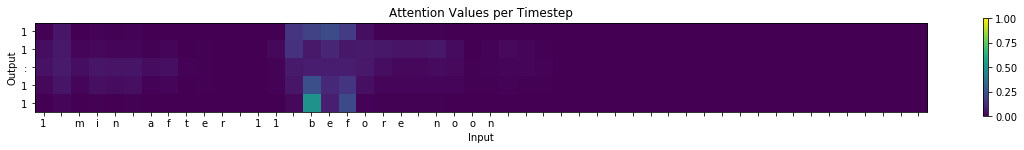

In [16]:
i = random.randint(0, m)

def plot_attention_graph(model, x, Tx, Ty, human_vocab, layer=7):
    # Process input
    tokens = np.array([tokenize(x, human_vocab, Tx)])
    tokens_oh = oh_2d(tokens, len(human_vocab))
    
    # Monitor model layer
    layer = model.layers[layer]
    
    layer_over_time = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    layer_output = layer_over_time([tokens_oh])
    layer_output = [row.flatten().tolist() for row in layer_output]
    
    # Get model output
    prediction = get_prediction(model, tokens_oh)[1]
    
    # Graph the data
    fig = plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(1.8)
    ax = fig.add_subplot(111)
    
    plt.title("Attention Values per Timestep")
    
    plt.rc('figure')
    cax = plt.imshow(layer_output, vmin=0, vmax=1)
    fig.colorbar(cax)
    
    plt.xlabel("Input")
    ax.set_xticks(range(Tx))
    ax.set_xticklabels(x)
    
    plt.ylabel("Output")
    ax.set_yticks(range(Ty))
    ax.set_yticklabels(prediction)
    
    plt.show()
    
plot_attention_graph(model, dataset[i][0], Tx, Ty, human_vocab)